In [1]:
import pandas as pd
import os
import shutil
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit 
from PIL import Image
import torch
import torchvision.transforms as T
from torchvision.io import read_image
from torchvision.utils import save_image
import torchvision
import matplotlib.pyplot as plt
import numpy as np

In [2]:
updated_data_dir = ""
updated_labels = pd.read_csv(os.path.join(updated_data_dir,'train_df.csv'))

Drop labels that are not used

In [8]:
selected_updated_labels = updated_labels.drop(['Hernia', 'Pneumonia', 'Fibrosis', 'Edema', 'Emphysema', 'Cardiomegaly',
       'Pleural_Thickening', 'Consolidation'], axis=1)

Get rows that are single labeled

In [9]:
selected_updated_labels = selected_updated_labels.loc[updated_labels[['Effusion', 'No Finding', 'Infiltration',
                                                    'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax']].sum(axis=1)==1]\
                               .reset_index(drop=True)

In [10]:
selected_updated_labels['label'] = selected_updated_labels[['Effusion', 'No Finding', 'Infiltration',
                'Mass', 'Nodule', 'Atelectasis', 'Pneumothorax']].idxmax(axis=1)

Reduce dataset size by dropping multiple No Finding images of the same patient

In [11]:
base_class = selected_updated_labels.loc[(selected_updated_labels['label']=="No Finding")].reset_index(drop=True)
other_classes = selected_updated_labels.loc[~(selected_updated_labels['label']=="No Finding")].reset_index(drop=True)
base_class_sample = base_class.groupby(['Patient ID', 'label'])['FilePath'].sample(1)
base_class = base_class.iloc[base_class_sample.index][['Patient ID', 'label', 'FilePath']]
other_classes = other_classes[['Patient ID', 'label', 'FilePath']]

In [12]:
dataset = pd.concat([base_class, other_classes], ignore_index=1)

Split data into train, val and test sets by patient ID

In [158]:
random_state = 30
splitter = GroupShuffleSplit(test_size=.30, n_splits=1, random_state = random_state)
split = splitter.split(dataset, groups=dataset['Patient ID'])
train_inds, test_inds = next(split)

labels_test_val = dataset.iloc[test_inds]

splitter = GroupShuffleSplit(test_size=.50, n_splits=1, random_state = random_state)
split = splitter.split(labels_test_val, groups=labels_test_val['Patient ID'])
val_inds, test_inds = next(split)

In [159]:
train = dataset.iloc[train_inds].reset_index(drop=True)
val = labels_test_val.iloc[val_inds].reset_index(drop=True)
test = labels_test_val.iloc[test_inds].reset_index(drop=True)

In [161]:
total = train.shape[0] + val.shape[0] + test.shape[0]
print((train.shape[0])/total)
print(val.shape[0]/total)
print(test.shape[0]/total)

0.6980413881839952
0.15188176846920906
0.1500768433467958


Check for data leak

In [162]:
def check_data_leak(train, test):
    return set(train['Patient ID']).intersection(set(test['Patient ID']))

In [163]:
print(check_data_leak(dataset.iloc[train_inds], labels_test_val.iloc[test_inds]))
print(check_data_leak(dataset.iloc[train_inds], labels_test_val.iloc[val_inds]))
print(check_data_leak(labels_test_val.iloc[val_inds], labels_test_val.iloc[test_inds]))

set()
set()
set()


In [164]:
train['FilePath'] = train['FilePath'].str[14:]
val['FilePath'] = val['FilePath'].str[14:]
test['FilePath'] = test['FilePath'].str[14:]

In [173]:
for j in ['train', 'val', 'test']:   
    os.mkdir(f"base/{j}")
    for i, _ in {'No Finding': 0, 'Effusion': 1, 'Infiltration': 2,
           'Mass': 3, 'Nodule': 4, 'Atelectasis': 5, 'Pneumothorax': 6}.items():
        os.mkdir(f"base/{j}/{i}")

In [166]:
train.to_csv("train.csv", index=False)
val.to_csv("val.csv", index=False)
test.to_csv("test.csv", index=False)

Copy images to correct folders

In [174]:
for idx, row in tqdm(test.iterrows()):
    shutil.copy2(row.FilePath, f"base/test/{row.label}/") # target filename is /dst/dir/file.ext

8398it [00:38, 218.99it/s]


In [175]:
for idx, row in tqdm(val.iterrows()):
    shutil.copy2(row.FilePath, f"base/val/{row.label}/") # target filename is /dst/dir/file.ext

8499it [00:27, 306.64it/s]


In [176]:
for idx, row in tqdm(train.iterrows()):
    shutil.copy2(row.FilePath, f"base/train/{row.label}/") # target filename is /dst/dir/file.ext

39061it [02:39, 244.62it/s]


In [177]:
for j in ['train', 'val', 'test']:   
    os.mkdir(f"resized/{j}")
    for i, _ in {'No Finding': 0, 'Effusion': 1, 'Infiltration': 2,
           'Mass': 3, 'Nodule': 4, 'Atelectasis': 5, 'Pneumothorax': 6}.items():
        os.mkdir(f"resized/{j}/{i}")

In [49]:
for j in ['train', 'val', 'test']:   
    os.mkdir(f"resized_processed/{j}")
    for i, _ in {'No Finding': 0, 'Effusion': 1, 'Infiltration': 2,
           'Mass': 3, 'Nodule': 4, 'Atelectasis': 5, 'Pneumothorax': 6}.items():
        os.mkdir(f"resized_processed/{j}/{i}")

im = Image.open("images_001/images/00000002_000.png")
width, height = im.size

im.resize((384,384), resample=Image.LINEAR)#.save()

In [3]:
train = pd.read_csv("resized/train.csv")
val = pd.read_csv("resized/val.csv")
test = pd.read_csv("resized/test.csv")

In [25]:
im = read_image("images_001/images/00000002_000.png", mode=torchvision.io.ImageReadMode.GRAY)
im = T.functional.equalize(im)
im = T.functional.gaussian_blur(im, kernel_size=(5, 5), sigma=None)
im1 = T.Resize(size=(384))(im)

In [26]:
im = read_image("images_001/images/00000002_000.png", mode=torchvision.io.ImageReadMode.GRAY)
im = T.Resize(size=(384))(im)
im = T.functional.equalize(im)
im2 = T.functional.gaussian_blur(im, kernel_size=(5, 5), sigma=None)

In [33]:
from torchvision.utils import save_image

In [38]:
save_image(im1/255., 'im1.png')
save_image(im2/255., 'im2.png')

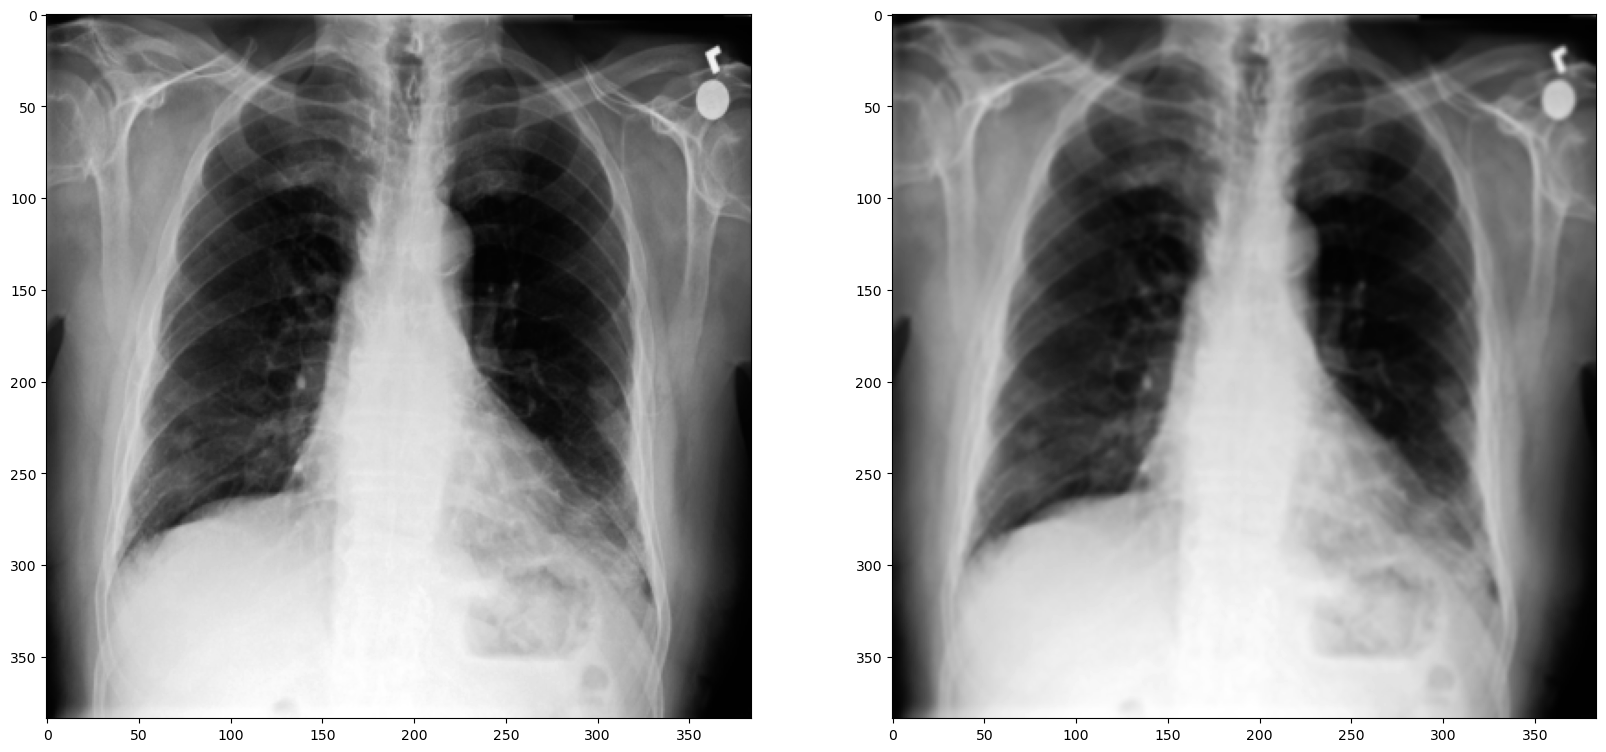

In [32]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(np.transpose(im1.numpy(), (1, 2, 0)), cmap = 'gray')
ax[1].imshow(np.transpose(im2.numpy(), (1, 2, 0)), cmap = 'gray')

In [180]:
train.head(2)

,Patient ID,label,FilePath
0,2,No Finding,images_001/images/00000002_000.png
1,5,No Finding,images_001/images/00000005_003.png


Pre-process and resize images

In [52]:
for idx, row in tqdm(test.iterrows()):
    im = read_image(row.FilePath, mode=torchvision.io.ImageReadMode.GRAY)
    imP = T.functional.equalize(im)
    imP = T.functional.gaussian_blur(imP, kernel_size=(5, 5), sigma=None)
    im = T.Resize(size=(384))(im)
    imP = T.Resize(size=(384))(imP)
    save_image(im/255., f"resized/test/{row.label}/{row.FilePath.split('/')[-1]}")
    save_image(imP/255., f"resized_processed/test/{row.label}/{row.FilePath.split('/')[-1]}")

8398it [25:06,  5.58it/s]


In [55]:
for idx, row in tqdm(val.iterrows()):
    im = read_image(row.FilePath, mode=torchvision.io.ImageReadMode.GRAY)
    imP = T.functional.equalize(im)
    imP = T.functional.gaussian_blur(imP, kernel_size=(5, 5), sigma=None)
    im = T.Resize(size=(384))(im)
    imP = T.Resize(size=(384))(imP)
    save_image(im/255., f"resized/val/{row.label}/{row.FilePath.split('/')[-1]}")
    save_image(imP/255., f"resized_processed/val/{row.label}/{row.FilePath.split('/')[-1]}")

8499it [25:44,  5.50it/s]


In [56]:
for idx, row in tqdm(train.iterrows()):
    im = read_image(row.FilePath, mode=torchvision.io.ImageReadMode.GRAY)
    imP = T.functional.equalize(im)
    imP = T.functional.gaussian_blur(imP, kernel_size=(5, 5), sigma=None)
    im = T.Resize(size=(384))(im)
    imP = T.Resize(size=(384))(imP)
    save_image(im/255., f"resized/train/{row.label}/{row.FilePath.split('/')[-1]}")
    save_image(imP/255., f"resized_processed/train/{row.label}/{row.FilePath.split('/')[-1]}")

39061it [2:00:52,  5.39it/s]


In [96]:
image_path = os.path.join("C:\\Users\Maedr3\Downloads\ChestXRay8", "images_012/images/00030000_003.png")

In [97]:
im = read_image(image_path, mode=torchvision.io.ImageReadMode.GRAY)
im = T.functional.equalize(im)
im1 = T.functional.gaussian_blur(im, kernel_size=(5, 5), sigma=None)
#im1 = T.Resize(size=(384))(im1)

In [98]:
im2 = read_image(image_path, mode=torchvision.io.ImageReadMode.GRAY)
#im = T.Resize(size=(384))(im)
#im2 = T.functional.equalize(im)
#im2 = T.functional.gaussian_blur(im2, kernel_size=(5, 5), sigma=None)

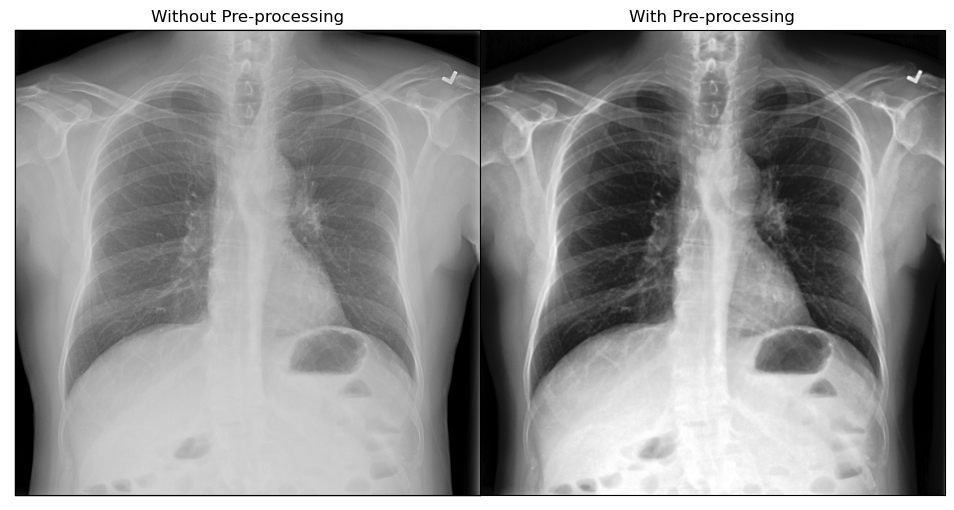

In [110]:
fig = plt.figure(figsize=(12, 8))
gs = fig.add_gridspec(1, 2, hspace=0, wspace=0)
ax1, ax2 = gs.subplots(sharex='col', sharey='row')

ax1.imshow(np.transpose(im2.numpy(), (1, 2, 0)), cmap = 'gray')
ax2.imshow(np.transpose(im1.numpy(), (1, 2, 0)), cmap = 'gray')

ax1.title.set_text('Without Pre-processing')
ax2.title.set_text('With Pre-processing')

ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_yticklabels([])
ax1.set_xticklabels([])

ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_yticklabels([])
ax2.set_xticklabels([])

ax1.patch.set_edgecolor('black')  
ax1.patch.set_linewidth('1')  
fig.savefig("pre_proc_img.eps", format="eps", dpi=1200, bbox_inches="tight", transparent=True)

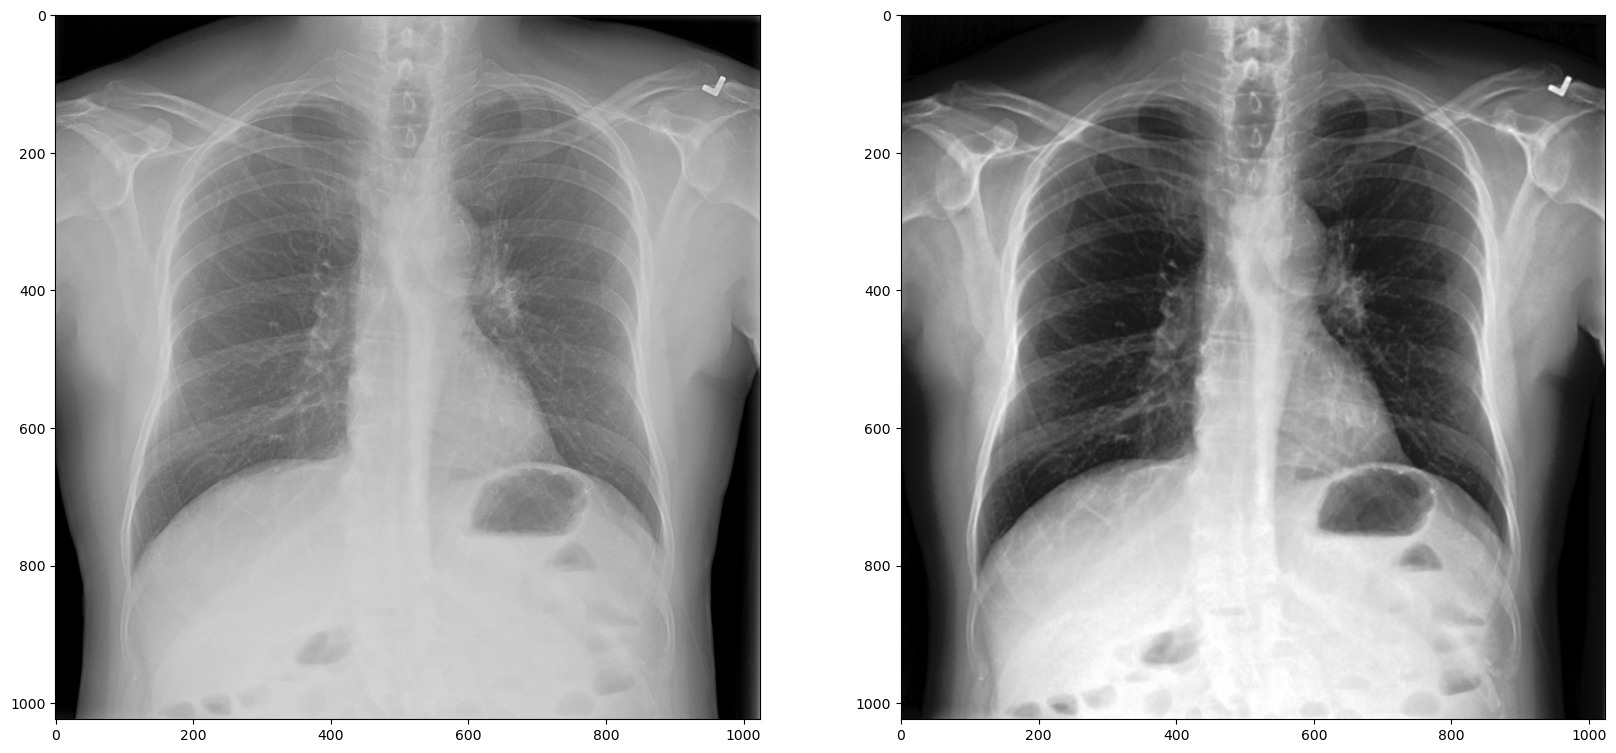

In [99]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
ax[0].imshow(np.transpose(im2.numpy(), (1, 2, 0)), cmap = 'gray')
ax[1].imshow(np.transpose(im1.numpy(), (1, 2, 0)), cmap = 'gray')

save_image(im1/255., 'im1.png')
save_image(im2/255., 'im2.png')

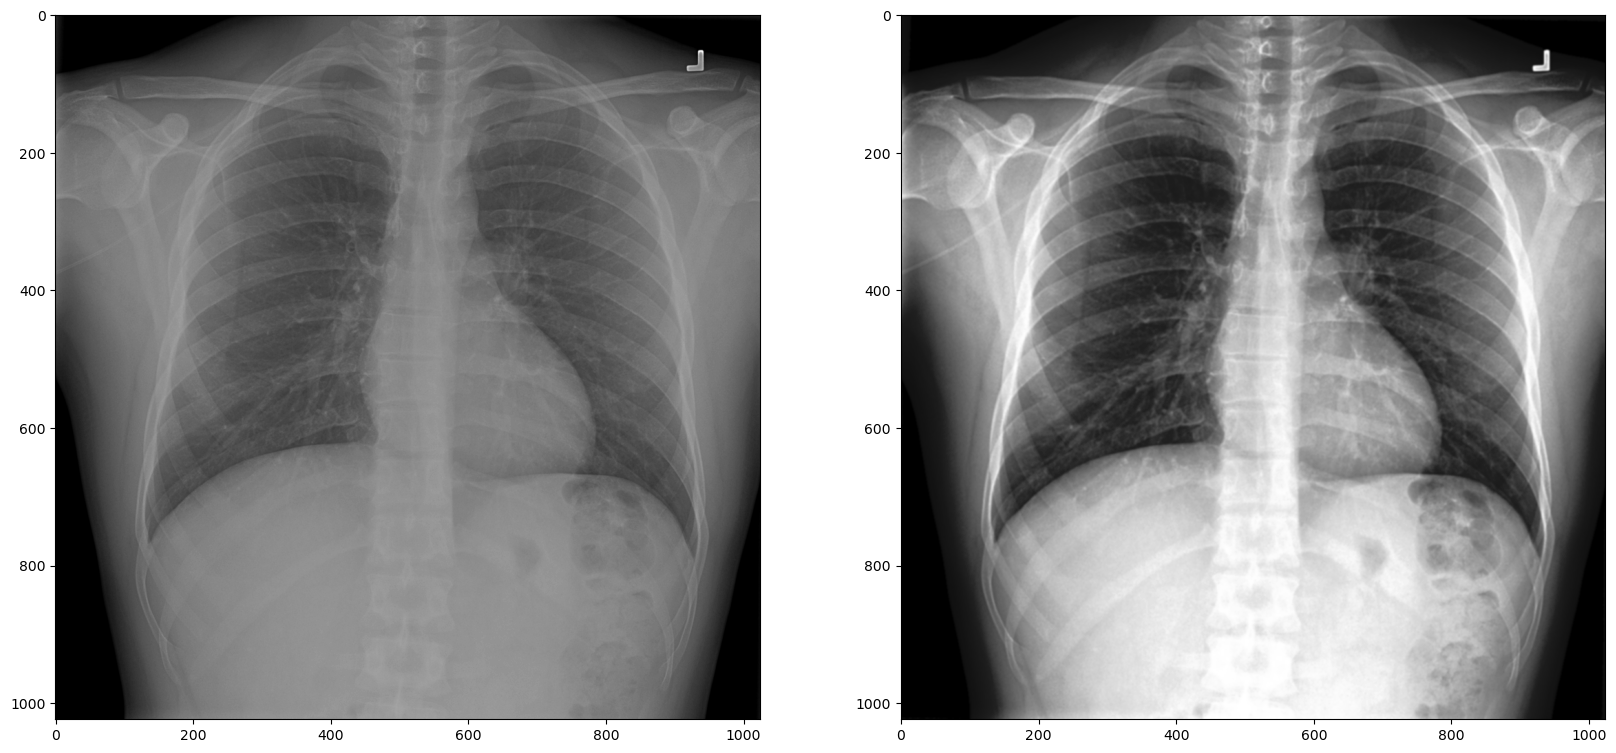